<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumSubjectsClassifier_13_Spacy_Textcat_First10Pages_fewer_bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import spacy
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [4]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [5]:

texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]
    # Limit to first 3 pages because of memory constraints
    if len(pages) > 10:
      pages = pages[:10]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [6]:
 del file_to_pages

In [7]:
df_annotations = df_annotations[~df_annotations.num_subjects.isna()]

In [8]:
df_annotations["num_subjects"].value_counts()

20.0      198
10.0      179
24.0      174
30.0      174
12.0      160
         ... 
1311.0      1
598.0       1
1300.0      1
2218.0      1
4891.0      1
Name: num_subjects, Length: 1444, dtype: int64

In [9]:
for i in np.quantile(df_annotations["num_subjects"], [0, 0.2, 0.4, 0.6, 0.8, 1]):
  print (int(np.float(i)))

0
20
44
100
290
1371146


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [10]:
def get_num_subjects_clean(num):
    if pd.isna(num):
        return None
    # if num >= 10000:
    #     return "10000+"
    # if num >= 1000:
    #     return "1000+"
    if num >= 290:
        return "290+"
    if num >= 100:
        return "100+"
    if num >= 45:
        return "45+"
    if num >= 20:
        return "20+"
    return "1-24"
df_annotations["num_subjects_clean"] = df_annotations["num_subjects"].apply(get_num_subjects_clean)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
df_annotations["num_subjects_clean"].value_counts()

20+     2488
100+    2416
290+    2389
45+     2324
1-24    2303
Name: num_subjects_clean, dtype: int64

In [12]:
labels = list(sorted(set(df_annotations["num_subjects_clean"]), key =lambda x : int(re.sub(r'\D.*', '', x))))
labels

['1-24', '20+', '45+', '100+', '290+']

In [ ]:
import spacy
nlp = spacy.blank("en")
from spacy.tokens import DocBin

docs_train = []
for i in range(10):
  docs_train.append(DocBin())
docs_val = DocBin()

for idx in range(len(df_annotations)):
  if idx % 100 == 0:
    print (idx, len(df_annotations))
  if df_annotations.train_val.iloc[idx] == "train":
    docs_list = docs_train[idx % 10]
  else:
    docs_list = docs_val
  text = str(df_annotations.text.iloc[idx])
  if len(text) > 100000:
      text = text[:100000]
  doc = nlp(text)

  cats = {}
  for a in labels:
      cats[a] = 0
  if pd.isna(df_annotations.num_subjects_clean.iloc[idx]):
    continue
  cats[df_annotations.num_subjects_clean.iloc[idx]] = 1
  doc.cats = cats

  docs_list.add(doc)

0 11920
100 11920
200 11920
300 11920


KeyboardInterrupt: ignored

In [ ]:
!mkdir train.spacy
!mkdir /content/drive/MyDrive/data/subjects_13_train.spacy


In [ ]:
for idx, doc_bin_train in enumerate(docs_train):
  doc_bin_train.to_disk(f"train.spacy/train_doc_bin{idx}.spacy")
  doc_bin_train.to_disk(f"/content/drive/MyDrive/data/subjects_13_train.spacy/train_doc_bin{idx}.spacy")

In [ ]:
!ls /content/drive/MyDrive/data/subjects_13_train.spacy

train_doc_bin0.spacy  train_doc_bin4.spacy  train_doc_bin8.spacy
train_doc_bin1.spacy  train_doc_bin5.spacy  train_doc_bin9.spacy
train_doc_bin2.spacy  train_doc_bin6.spacy
train_doc_bin3.spacy  train_doc_bin7.spacy


In [ ]:
docs_val.to_disk("dev.spacy")

In [ ]:
docs_val.to_disk("/content/drive/MyDrive/data/subjects_13_dev.spacy")

In [ ]:
!python -m spacy train ./spacy_textcat_is_international_11.cfg --output /content/drive/MyDrive/data/output_subjects_13 --paths.train /content/drive/MyDrive/data/subjects_13_train.spacy --paths.dev  /content/drive/MyDrive/data/subjects_13_dev.spacy --gpu-id 0

ℹ Saving to output directory:
/content/drive/MyDrive/data/output_subjects_13
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-11-18 10:44:43,965] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-18 10:44:43,975] [INFO] Pipeline: ['textcat']
INFO:spacy:Pipeline: ['textcat']
[2022-11-18 10:44:43,978] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-18 10:44:43,979] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
[2022-11-18 10:55:12,067] [INFO] Initialized pipeline components: ['textcat']
INFO:spacy:Initialized pipeline components: ['textcat']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.0
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
tcmalloc: large alloc 1073750016 bytes == 0x7f7d7ff4e000 @  0x7f81b

In [13]:
import spacy
nlp = spacy.load("/content/drive/MyDrive/data/output_subjects_13/model-best")

In [14]:
df_val = df_annotations[df_annotations.train_val=="val"]

predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [15]:
# pred_proba = []
# for idx in range(len(df_val)):
#     pred_proba.append([predictions[idx][a] for a in range(num_classes)])

In [16]:
predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [17]:
df_val["y_pred"] = [max(p, key=p.get) for p in predictions]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
num_subjects_ground_truths = df_val.num_subjects_clean
pred_num_subjects = df_val["y_pred"]

In [19]:
acc = accuracy_score(num_subjects_ground_truths, pred_num_subjects)
print (f"Num subjects accuracy {acc}")

Num subjects accuracy 0.2921658986175115


''

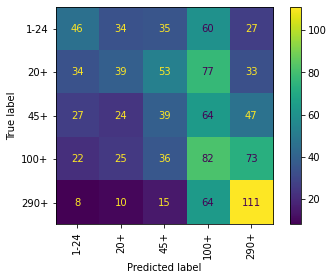

In [20]:
ConfusionMatrixDisplay.from_predictions(num_subjects_ground_truths, pred_num_subjects, labels=labels)
plt.xticks(rotation=90)
;

In [21]:
all_aucs = []
from sklearn.metrics import roc_auc_score
for i in labels:
  roc_auc = roc_auc_score(num_subjects_ground_truths == i, [p[i] for p in predictions])
  print (f"Num subjects ROC AUC {roc_auc} for {i} subjects")
  all_aucs.append(roc_auc)
print ("Average", np.mean(all_aucs))

Num subjects ROC AUC 0.6399818351031026 for 1-24 subjects
Num subjects ROC AUC 0.5341553372861392 for 20+ subjects
Num subjects ROC AUC 0.5455415231534634 for 45+ subjects
Num subjects ROC AUC 0.536639449168097 for 100+ subjects
Num subjects ROC AUC 0.7340145601263046 for 290+ subjects
Average 0.5980665409674214


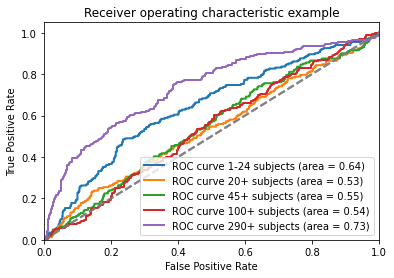

In [22]:
plt.figure()
lw = 2
    
for i in labels:
    fpr, tpr, _ = roc_curve(num_subjects_ground_truths == i, [p[i] for p in predictions])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve {i} subjects (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [23]:
# Delete this afterwards:
# !python -m spacy train ./spacy_textcat_is_international_11.cfg --output /content/drive/MyDrive/data/output_country_16 --paths.train /content/drive/MyDrive/data/country_16_train.spacy --paths.dev  /content/drive/MyDrive/data/country_16_dev.spacy --gpu-id 0

In [24]:
1

1